In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import dates
from netCDF4 import num2date,date2num,Dataset
import matplotlib.cm as cm
import time,os,subprocess
import copy
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec
from math import radians, sin, cos, sqrt, asin
import scipy.interpolate as interpolate
import pyart.graph.cm as pcm
import cPickle as pickle
import datetime
import pyproj
import scipy.ndimage as ndi
import mahotas,pymorph,pylab
import pims
import trackpy as tp
from PIL import Image
from marcus_py_tools import make_edge_vec, xy_from_latlon, latlon_from_xy, walklevel, find_stuff_at_level,haversine
%matplotlib inline

## Tracking KDP/ZDR columns in Houston NEXRAD data using TrackPy
We will follow on the techniques used in kdp_cell_tracker.ipynb, with the following innovations:
- We will use KDP and ZDR "potential energy" which is $K_{DP}*h $, where h is height
- We now use new version of trackpy (maybe this is a pain in the ass)
- We are older and wiser nowaday

The motivation behind KDP and ZDR "potential energy" is as follows: we are concerned not only with the height of KDP/ZDR columns, but with the values of KDP/ZDR within them (and maybe this is more true for KDP than ZDR). 

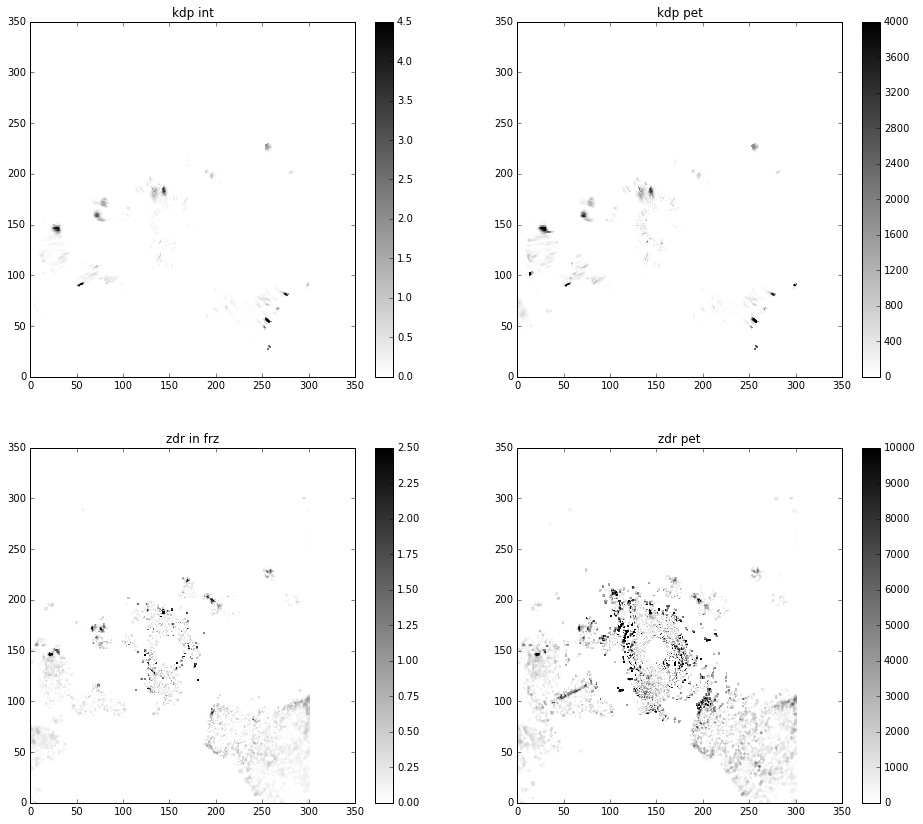

In [2]:
#..First let's consider *how* exactly we will identify these objects. We will attempt to use "KDP potential energy"
#..to identify these features. Let us start by looking at a single, suggestive time from KHGX
filenm = '/home/mvanlier/mvanlier/nexrad_khgx/20130608/grid02_khgx_20130608_202447.nc'
#filenm = '/home/mvanlier/mvanlier/nexrad_khgx/20130608/grid01_khgx_20130608_202447.nc'
#filenm = '/home/mvanlier/mvanlier/nexrad_khgx/20130722/grid00_khgx_20130722_172959.nc'
khgx_lat = 29.468
khgx_lon = -95.075
radr_lat = khgx_lat
radr_lon = khgx_lon

zsfc = 35.   #..m (= 115 feet)
nc = Dataset(filenm,'r')
xd = nc.variables['x_disp'][:]
yd = nc.variables['y_disp'][:]
zd = nc.variables['z_disp'][:]
#..Make vectors of cell edges
xe = make_edge_vec(xd)
ye = make_edge_vec(yd)
ze = make_edge_vec(zd)
alt= zd + zsfc
alte=ze + zsfc
zhh = nc.variables['reflectivity'][0,:,:,:]
zdr = nc.variables['differential_reflectivity'][0,:,:,:]
kdp = nc.variables['kdp'][0,:,:,:]
rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
nc.close()

#..Get lat/lon from dx,dy
lat_grid,lon_grid = latlon_from_xy(xd,yd,radr_lat,radr_lon)
#..
zgrid = np.zeros((len(zd),len(yd),len(xd)))
for j in range(len(zd)):
    zgrid[j,:,:] = zd[j]

#..
zdr_proc = copy.deepcopy(zdr)
zdr_proc = np.ma.masked_values(zdr_proc,-9999.)
kdp_proc = copy.deepcopy(kdp)
kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
kdp_proc = np.ma.masked_where(rho<.8,kdp_proc)
kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
#kdp_proc = np.ma.masked_where(zhh<20.,kdp_proc)
kdp_int = kdp_proc[9:15,:,:].sum(axis=0)

vol_ones = zdr_proc*0.+1
kdp_pe = kdp_proc*zgrid
zdr_pe = zdr_proc*zgrid
kdp_pet = kdp_pe[9:17,:,:].sum(axis=0)/vol_ones[9:17,:,:].sum(axis=0)
zdr_pet = zdr_pe[9:17,:,:].sum(axis=0)/vol_ones[9:17,:,:].sum(axis=0)


#..Plot
fig = plt.figure(figsize=(16,14))
ax = fig.add_subplot(221)
aa = ax.pcolormesh(kdp_int[50:351,50:351],cmap=cm.gray_r,vmin=0,vmax=4.5)
plt.title('kdp int')
plt.colorbar(aa)
ax = fig.add_subplot(222)
ab = ax.pcolormesh(kdp_pet[50:351,50:351],cmap=cm.gray_r,vmin=0,vmax=4000.)
plt.colorbar(ab)
plt.title('kdp pet')
ax = fig.add_subplot(223)
ba = ax.pcolormesh(zdr[11,50:351,50:351],cmap=cm.gray_r,vmin=0.,vmax=2.5)
plt.colorbar(ba)
plt.title('zdr in frz')
ax = fig.add_subplot(224)
bb = ax.pcolormesh(zdr_pet[50:351,50:351],cmap=cm.gray_r,vmin=0.,vmax=10000)
plt.colorbar(bb)
plt.title('zdr pet')
#..

In [3]:
def normalize_array(array_in,minval=0,maxval=255,integerout=True,invert=False):
    array_out = copy.deepcopy(array_in)
    array_out[array_out<0.] = 0.  #..Here is subzero, now plain zero
    #..we lazily assume the minimum is zero...
    array_out = maxval*array_out/(array_out.max())
    if integerout:
        array_out = array_out.astype(np.uint8)
    if invert:
        array_out = maxval-array_out
    return array_out

### Moving on to implementation of feature ID and tracking
We will go forward with kdp_pe, even though it does not seem to offer an obvious advantage over kdp_int. We make this choice because this metric makes *more sense*. The main thing is getting trackpy to read it. 


We will do this as a start, and maybe do something fancy with ZDR later. To use ZDR, it may be necessary to use image processing to remove the background (see here: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_regional_maxima.html#example-color-exposure-plot-regional-maxima-py  or here: http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_threshold_adaptive.html#example-segmentation-plot-threshold-adaptive-py )

The way to do this is: load and processing data as numpy arrays, save in a temp file as tiff images, use trackpy to load tiff and track tiff images. Then use the tracks from trackpy with numpy arrays to do all the analysis. 

In [8]:
print 'test'

test


### First, process files into TIFF images of "KDP potential energy"

In [99]:
#..Get a list of radar data files. 
#nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130619/'
nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130608/'
#nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130722/'
#radfile_start = 'grid00_khgx'
#radfile_start = 'grid01_khgx'
radfile_start = 'grid02_khgx'
numfiles = 0
radfiles = []
for root,dirs,files in walklevel(nexrad_path,level=0):
    for file in files:
        if file.startswith(radfile_start):
            radfiles.append(file)
            numfiles += 1
#print radfiles
radfiles = sorted(radfiles)
filenm = radfiles[0]

#..Load up things that don't change file-by-file
filenm = nexrad_path+radfiles[0]
nc = Dataset(filenm,'r')
xd = nc.variables['x_disp'][:]
yd = nc.variables['y_disp'][:]
zd = nc.variables['z_disp'][:]
#..Make vectors of cell edges
xe = make_edge_vec(xd)
ye = make_edge_vec(yd)
ze = make_edge_vec(zd)
alt= zd + zsfc
alte=ze + zsfc
#..Get lat/lon from dx,dy
lat_grid,lon_grid = latlon_from_xy(xd,yd,radr_lat,radr_lon)
#..
zgrid = np.zeros((len(zd),len(yd),len(xd)))
for j in range(len(zd)):
    zgrid[j,:,:] = zd[j]
nc.close()

#..Loop and load and analyze radar data to get kdp potential energy
for i in xrange(numfiles):
    filenm =nexrad_path+radfiles[i]
    nc = Dataset(filenm,'r')
    zhh = nc.variables['reflectivity'][0,:,:,:]
    zdr = nc.variables['differential_reflectivity'][0,:,:,:]
    kdp = nc.variables['kdp'][0,:,:,:]
    rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
    nc.close()

    kdp_proc = copy.deepcopy(kdp)
    kdp_proc[rho<.8] = 0.
    kdp_proc[zhh<15.] = 0.
    kdp_proc[kdp_proc==-9999.] = 0.
    #kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
    #kdp_proc = np.ma.masked_where(rho<.8,kdp_proc)
    #kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
    #kdp_proc = np.ma.masked_where(zhh<20.,kdp_proc)
    #kdp_int = kdp_proc[9:15,:,:].sum(axis=0)

    vol_ones = kdp_proc*0.+1
    kdp_pet = (zgrid[9:17,:,:]*kdp_proc[9:17,:,:]).sum(axis=0)/vol_ones[9:17,:,:].sum(axis=0)
    kdp_pet[kdp_pet>3000.]=3000.

    kdp_pet_proc = normalize_array(kdp_pet,invert=True)
    
    #..
    img = Image.fromarray(kdp_pet_proc)
    img.save('temp4/kdp_pe_'+str(i).zfill(3)+'.tiff')

### Now load one of these images to fine-tune detection

In [100]:
frames = pims.ImageSequence('temp3/*.tiff', as_grey=True)
framesa = pims.ImageSequence('temp4/*.tiff', as_grey=True)
#..

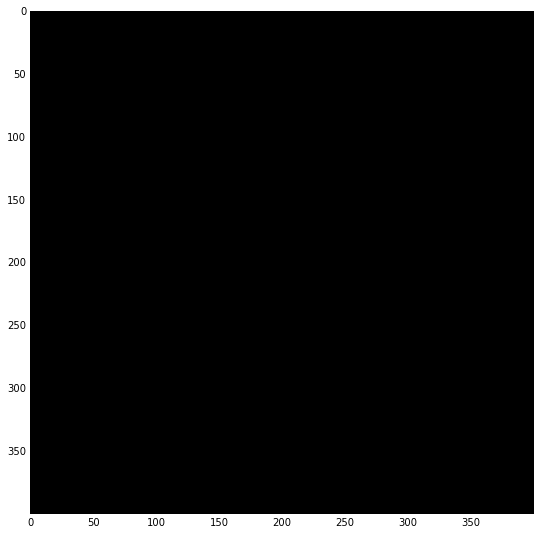

In [101]:
plt.figure(figsize=(10,9))
#plt.imshow(frames[87],cmap=cm.gray)
plt.imshow(frames[87]-framesa[87],cmap=cm.gray)
#..

In [45]:
f = tp.locate(frames[87], 11, invert=True)

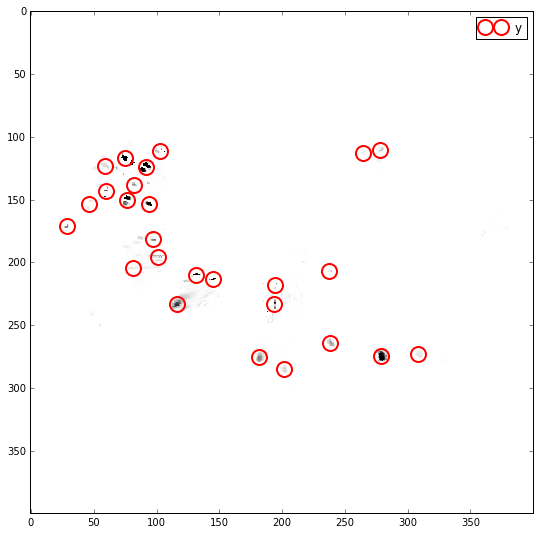

In [46]:
plt.figure(figsize=(10,9))  # make a new figure
tp.annotate(f, frames[87])

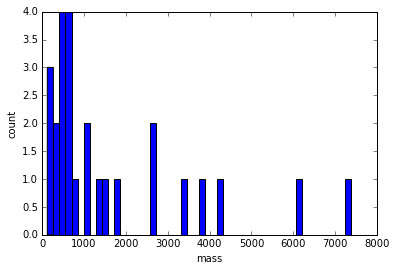

In [47]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=50)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count')

In [102]:
#..Locate features in all frames
f = tp.batch(frames[:], 11, invert=True)

Frame 118: 1 features


In [103]:
# 9 is about 30m/s
#..Link features into trajectories
t = tp.link_df(f, 9, memory=3)

Frame 118: 1 trajectories present


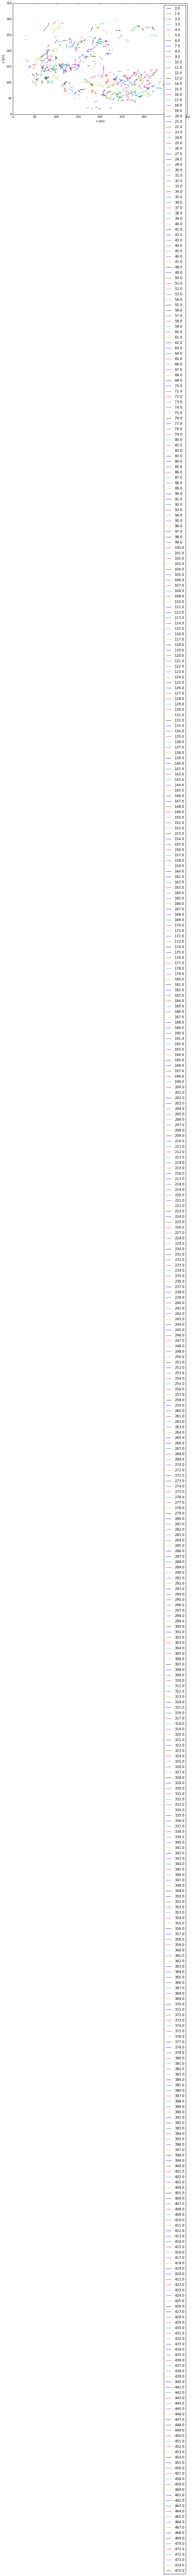

In [104]:
fig = plt.figure(figsize=(11,7))
#ax=fig.add_subplot(111)
ax = tp.plot_traj(t)
#ax = plt.gca()
ax.legend_.remove()
#ax.legend_ = None
#draw()

In [105]:
t1 = tp.filter_stubs(t, 6)
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

('Before:', 476)
('After:', 142)


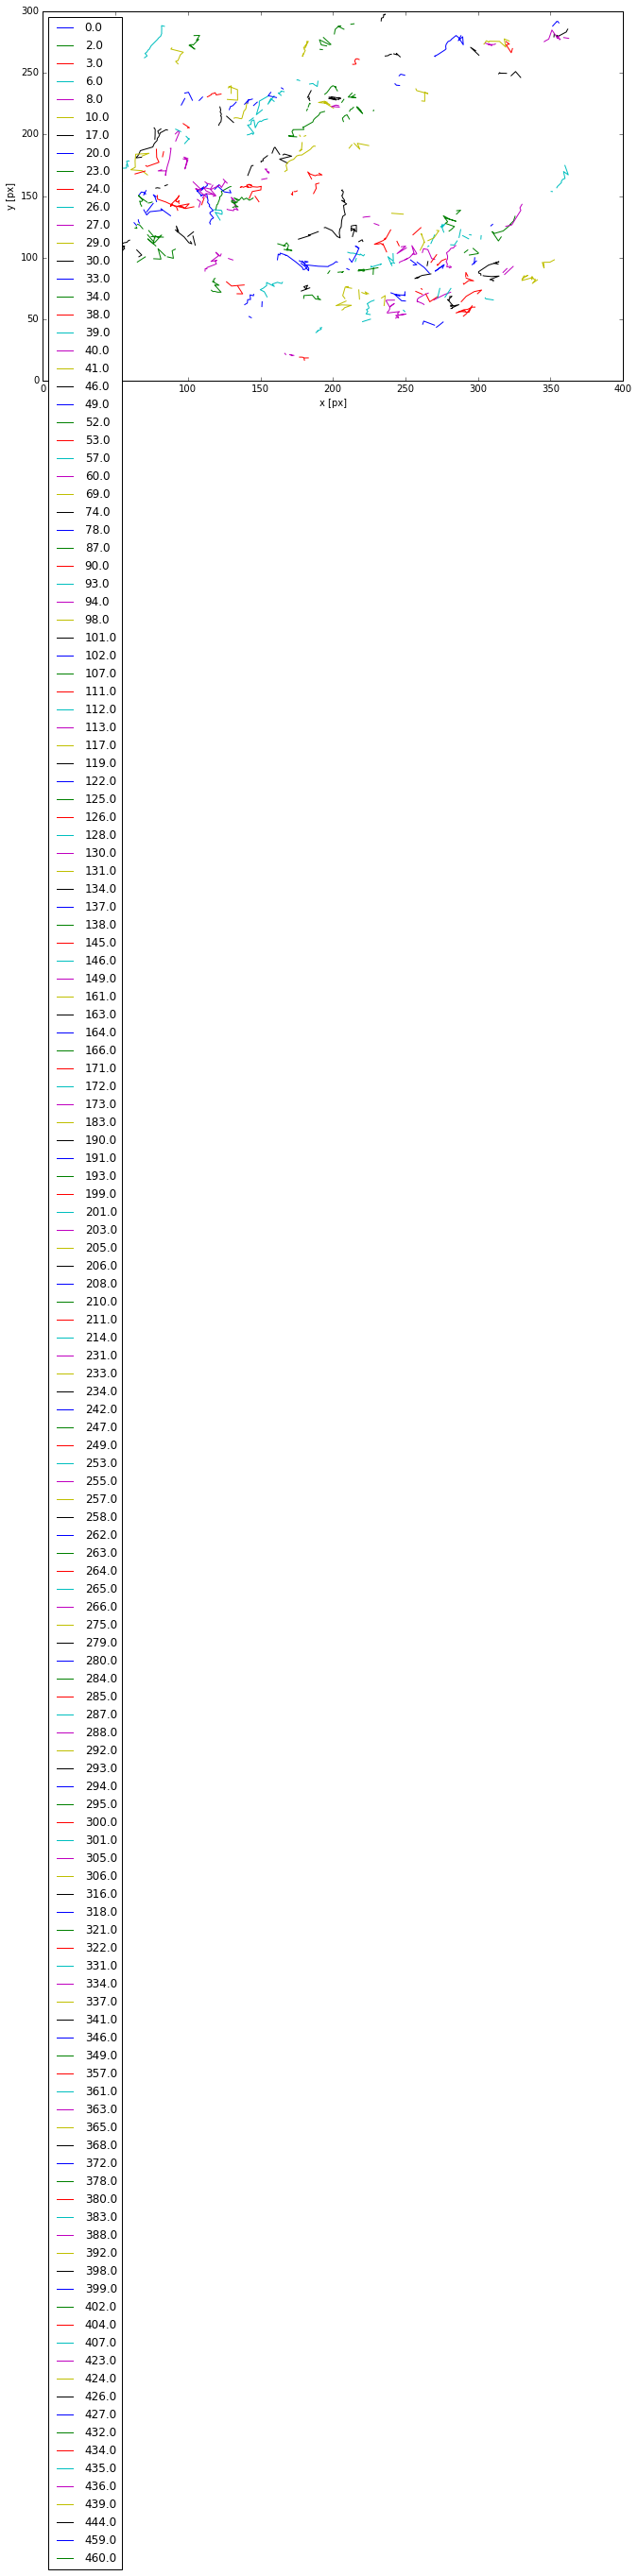

In [106]:
fig = plt.figure(figsize=(11,7))
#ax=fig.add_subplot(111)
ax = tp.plot_traj(t1)

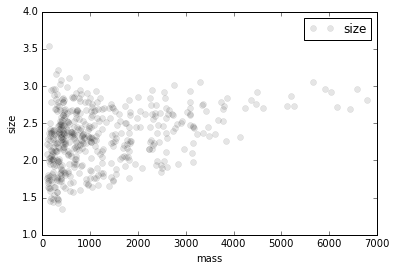

In [40]:
#..Look at appearance... ?
plt.figure()
tp.mass_size(t.groupby('particle').mean())  # convenience function -- just plots size vs. mass

## Code that loops over trajectories, analyzes and plots is shown below!
This is an amalgamem of code from plot_houston_lma and kdp_cell_tracker. At some point I may integrate an automatic html generator from html_mc3e_stratiform, to automate the generation of html files for animation. We will see!

In [306]:
def plot_track_map(orig_track_nos,real_track_nos,stix=None,enix=None,do_polygons=True):
    
    hx_lat = 29+45./60.+46./3600. 
    hx_lon = -1.*(95.+22./60+59./3600)
    
    fig=plt.figure(figsize=(10,9))
    #m = Basemap(width=400000,height=350000,projection='lcc',
    #                resolution='i',lon_0 =radr_lon,lat_0=radr_lat,lat_1=28.,lat_2=32.,epsg=2278)
    m = Basemap(llcrnrlon=-96.,llcrnrlat=29.,urcrnrlon=-94.5,urcrnrlat=30.5,epsg=2278,resolution='h') #..zoom 9
    #m = Basemap(llcrnrlon=-98.,llcrnrlat=28.,urcrnrlon=-93.8,urcrnrlat=31.3,epsg=2278,resolution='h') #..default
    #m = Basemap(llcrnrlon=-96.3,llcrnrlat=28.7,urcrnrlon=-93.8,urcrnrlat=30.3,epsg=4326,resolution='h')
    parallels = np.arange(round(radr_lat,0)-5.,round(radr_lat,0)+5,.5)
    meridians = np.arange(round(radr_lon,0)-5,round(radr_lon,0)+5,.5)
    #m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)
    m.arcgisimage(server='http://server.arcgisonline.com/ArcGIS', service='ESRI_Imagery_World_2D', 
                  xpixels=1000, ypixels=None, dpi=96, verbose=False)
    #plt.show()
    #m.bluemarble()
    #m.shadedrelief()
    #m.etopo()

    #m.imshow(img)
    m.tissot(radr_lon,radr_lat,108./60.,100,edgecolor='r',facecolor='none')
    m.tissot(radr_lon,radr_lat,108./120.,100,edgecolor='r',facecolor='none')
    m.plot(radr_lon,radr_lat,latlon=True,marker='s',color='r')
    m.plot(hx_lon,hx_lat,latlon=True,marker='s',color='w',markersize=10)
    #m.plot(-95.3,29.7,latlon=True,marker='s',color='g',markersize=10)
    m.drawparallels(parallels,color='w',labels=[True,False,False,False])
    m.drawmeridians(meridians,color='w',labels=[False,False,False,True])
    m.drawstates(color='w')
    m.drawcoastlines(color='w')
    
    if do_polygons:
        m.plot([-95.53,-95.08],[30.16,30.08],latlon=True,color='y',lw=2)
        m.plot([-95.573060,-95.53],[29.847739,30.16],latlon=True,color='y',lw=2)
        m.plot([-95.160033,-95.08],[29.772985,30.08],latlon=True,color='y',lw=2)
        m.plot([-95.573060,-95.160033],[29.847739,29.772985],latlon=True,color='y',lw=2)
        x,y = m(-95.08,30.08)
        plt.text(x-100000,y-5000.,'636@23%',fontsize=14,color='y')

        m.plot([-96.964975,-96.762590],[28.272033,28.364897],latlon=True,color='y',lw=2)
        m.plot([-96.964975,-96.850807],[28.272033,27.898124],latlon=True,color='y',lw=2)
        m.plot([-96.683910,-96.762590],[27.946578,28.364897],latlon=True,color='y',lw=2)
        x,y = m(-96.9649750,28.272033)
        plt.text(x-40000,y+5000.,'354@20%',fontsize=14,color='y')
        #m.plot([-95.160033,-95.08],[29.772985,30.08],latlon=True,color='y',lw=2)
        #m.plot([-95.573060,-95.160033],[29.847739,29.772985],latlon=True,color='y',lw=2)

        m.plot([-94.568841,-94.317973],[29.904596,29.819477],latlon=True,color='y',lw=2)
        m.plot([-94.723940,-94.469295],[29.716251,29.587392],latlon=True,color='y',lw=2)
        m.plot([-94.723940,-94.568841],[29.716251,29.904596],latlon=True,color='y',lw=2)
        m.plot([-94.469295,-94.317973],[29.587392,29.819477],latlon=True,color='y',lw=2)
        x,y = m(-94.568,29.9045)
        plt.text(x+5000,y,'482@23%',fontsize=14,color='y')

        m.plot([-97.766,-97.3],[29.15,29.169],latlon=True,color='y',lw=2)
        m.plot([-97.649,-97.279],[28.695,28.872],latlon=True,color='y',lw=2)
        m.plot([-97.766,-97.649],[29.15,28.695],latlon=True,color='y',lw=2)
        m.plot([-97.279,-97.3],[28.872,29.169],latlon=True,color='y',lw=2)
        x,y = m(-97.649,29.169)
        plt.text(x-10000,y+5000,'498@23%',fontsize=14,color='y')

        m.plot([-95.47,-95.00],[30.2,30.09],latlon=True,color='y',lw=2)
        m.plot([-95.35,-94.82],[30.7,30.6],latlon=True,color='y',lw=2)
        m.plot([-95.47,-95.35],[30.2,30.7],latlon=True,color='y',lw=2)
        m.plot([-95.00,-94.82],[30.09,30.6],latlon=True,color='y',lw=2)
        x,y = m(-94.82,30.6)
        plt.text(x,y,'762@23%',fontsize=14,color='y')

        x,y = m(hx_lon,hx_lat)
        plt.text(x-60000,y+1000.,'Houston',fontsize=18,color='w')

        x,y = m(radr_lon,radr_lat)
        plt.text(x-20000,y-14000.,'KHGX',fontsize=18,color='r')


    for j in range(len(orig_track_nos)):
        i = orig_track_nos[j]
        tmin = t1.frame[t1.particle==partnumlist[i]].min()
        tmax = t1.frame[t1.particle==partnumlist[i]].max()
        #print 'tmin,tmax = ',tmin,tmax
        nt = tmax-tmin+1
        ja = 0
        #..Set the start/end indices for the full timerange
        nex_hod_chop = []
        dsd_hod_chop = []
        dsd_idx_chop = []
        ja = 0
        #..Get a list of HOD
        for k in xrange(tmin,tmax+1):
            filenm = radfiles[k]
            rad_epoch = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10]),
                                           int(filenm[-9:-7]),int(filenm[-7:-5]),int(filenm[-5:-3])) -
                         datetime.datetime(1970,1,1)).total_seconds()
            nex_hod_chop = np.r_[nex_hod_chop,rad_epoch]

        nex_hod_chop = (nex_hod_chop - base_epoch)/3600.    #..s -> hr
        hod_chop_edge = make_edge_vec(nex_hod_chop)

        #..Pull together strings, time, lat, and lon, to allow for analysis to follow
        logcon = t1.particle==partnumlist[i]
        tidx = t1.index[logcon].values
        xidx = (np.around(t1.x[logcon].values)).astype(int)
        yidx = (np.around(t1.y[logcon].values)).astype(int)
        lon_track = lon_grid[[yidx,xidx]]
        lat_track = lat_grid[[yidx,xidx]]

        

        #..Make sure no time indices are being skipped. If they are, do an interpolation to reconstruct
        #..where the things should be going
        if (tidx.shape[0]==nex_hod_chop.shape[0]):
            print 'all is well, no gaps in the tracking, numsteps = ',nex_hod_chop.shape[0]
        else:
            print 'number of steps in track = ',tidx.shape[0],', should be =',nex_hod_chop.shape[0]
            tidx_new = np.array(range(tmin,tmax+1))
            f = interpolate.interp1d(tidx,t1.x[logcon].values)
            xidx = (np.around(f(tidx_new))).astype(int)
            f = interpolate.interp1d(tidx,t1.y[logcon].values)
            yidx = (np.around(f(tidx_new))).astype(int)
            lat_track = lat_grid[[yidx,xidx]]
            lon_track = lon_grid[[yidx,xidx]]
            tidx = tidx_new
        if enix:
            m.plot(lon_track[stix[j]:enix[j]],lat_track[stix[j]:enix[j]],color='c',lw=3,latlon=True)
            x,y = m(lon_track[stix[j]],lat_track[stix[j]])
            plt.text(x-10000,y-10000,str(real_track_nos[j]),color='c',fontsize=16)
        else:
            m.plot(lon_track,lat_track,color='c',lw=2,latlon=True)            
    fig.savefig('houston_track_map_09.png',dpi=100)

all is well, no gaps in the tracking, numsteps =  14
number of steps in track =  8 , should be = 13
number of steps in track =  9 , should be = 11


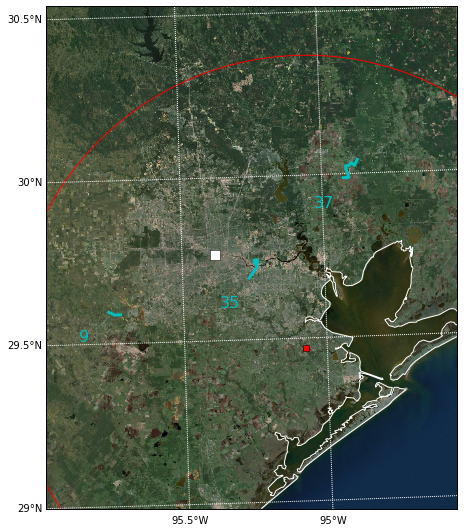

In [307]:
# rtn = np.array([9,35,37,49])
# otn = np.array([28,75,76,101])
# stix=[2,3,0,0]
# enix=[8,-1,9,-1]

rtn = np.array([9,35,37])
otn = np.array([28,75,76])
stix=[2,3,0]
enix=[8,-1,9]

plot_track_map(otn,rtn,stix=stix,enix=enix,do_polygons=False)
#plot_track_map(otn,rtn,stix=stix,enix=enix)
#..